In [7]:
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import ast
from heapq import heappush, heappop

In [8]:
# Step 1: Generate data
def generate_random_string(min_len=32, max_len=64):
    length = random.randint(min_len, max_len)
    result = ''.join(random.choices(string.ascii_lowercase, k=length))
    print(f"Generated string of length {length}: {result[:10]}...")  # Print first 10 characters
    return result

def get_shingles(text, k=4):
    shingles = set(text[i:i+k] for i in range(len(text) - k + 1))
    print(f"Generated {len(shingles)} shingles for text: {text[:10]}...")
    return shingles

# Create and save data
print("Starting data generation...")
data = []
for i in range(10000): 
    s = generate_random_string()
    shingles = get_shingles(s)
    data.append([i, s, str(shingles)])
    if (i + 1) % 100 == 0:
        print(f"Generated {i + 1} records")
df = pd.DataFrame(data, columns=['index', 'string', 'shingles'])
print("Saving data to dataset.csv...")
df.to_csv('dataset.csv', index=False)
print("Completed data generation and saving.")

Starting data generation...
Generated string of length 55: snshoemqco...
Generated 52 shingles for text: snshoemqco...
Generated string of length 58: gcpxeprwqm...
Generated 55 shingles for text: gcpxeprwqm...
Generated string of length 61: qqpylevspm...
Generated 58 shingles for text: qqpylevspm...
Generated string of length 34: qkcuhslhjy...
Generated 31 shingles for text: qkcuhslhjy...
Generated string of length 35: srdnydpxti...
Generated 32 shingles for text: srdnydpxti...
Generated string of length 64: ymakqoyfuk...
Generated 61 shingles for text: ymakqoyfuk...
Generated string of length 49: knsziqdmfm...
Generated 46 shingles for text: knsziqdmfm...
Generated string of length 56: zpwsfcjitv...
Generated 53 shingles for text: zpwsfcjitv...
Generated string of length 38: cutpleqdjc...
Generated 35 shingles for text: cutpleqdjc...
Generated string of length 59: cylzycyxmq...
Generated 56 shingles for text: cylzycyxmq...
Generated string of length 49: esdbougtak...
Generated 46 shin

In [9]:
# Step 2: Read data
print("Reading data from dataset.csv...")
df = pd.read_csv('dataset.csv')
data = [ast.literal_eval(row['shingles']) for _, row in df.iterrows()]
print(f"Read {len(data)} records from file.")

Reading data from dataset.csv...
Read 10000 records from file.


In [10]:
# Step 3: Implement AgglomerativeClustering
class AgglomerativeClustering:
    def __init__(self, data):
        print("Initializing AgglomerativeClustering...")
        self.data = data
        self.n_samples = len(data)
        self.clusters = [[i] for i in range(self.n_samples)]
        self.clustroids = list(range(self.n_samples))
        print(f"Number of samples: {self.n_samples}")
        print("Computing distance matrix...")
        self.distance_matrix = self.compute_distance_matrix()
        print("Completed distance matrix computation.")

    def jaccard_distance(self, set1, set2):
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        distance = 1 - intersection / union if union > 0 else 0
        return distance

    def compute_distance_matrix(self):
        print("Starting Jaccard distance matrix computation...")
        dist_matrix = np.zeros((self.n_samples, self.n_samples), dtype=np.float32)
        total_combinations = (self.n_samples * (self.n_samples - 1)) // 2
        count = 0
        for i, j in combinations(range(self.n_samples), 2):
            dist = self.jaccard_distance(self.data[i], self.data[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
            count += 1
            if count % 100000 == 0:
                print(f"Computed {count}/{total_combinations} distances...")
        print("Completed distance matrix computation.")
        return dist_matrix

    def compute_clustroid(self, cluster):
        if len(cluster) == 1:
            return cluster[0]
        min_sum_squared_dist = float('inf')
        clustroid = cluster[0]
        for i in cluster:
            sum_squared_dist = sum(self.distance_matrix[i][j]**2 for j in cluster)
            if sum_squared_dist < min_sum_squared_dist:
                min_sum_squared_dist = sum_squared_dist
                clustroid = i
        return clustroid

    def cluster_distance(self, idx1, idx2):
        clustroid1 = self.clustroids[idx1]
        clustroid2 = self.clustroids[idx2]
        return self.distance_matrix[clustroid1][clustroid2]

    def fit(self, n_clusters):
        print(f"Starting clustering with target of {n_clusters} clusters...")
        # Initialize heap with cluster pairs and distances
        heap = []
        print("Initializing heap with cluster pairs...")
        for i, j in combinations(range(len(self.clusters)), 2):
            dist = self.cluster_distance(i, j)
            heappush(heap, (dist, i, j))
        print(f"Pushed {len(heap)} pairs to heap.")

        iteration = 0
        while len(self.clusters) > n_clusters:
            print(f"Iteration {iteration + 1}: Currently {len(self.clusters)} clusters")
            # Get the closest cluster pair
            while heap:
                dist, i, j = heappop(heap)
                # Check if i, j are still valid (not merged)
                if i < len(self.clusters) and j < len(self.clusters):
                    break
            else:
                print("Heap is empty, cannot merge further.")
                break

            print(f"Merging clusters {i} and {j} with distance {dist:.4f}")
            # Merge clusters
            new_cluster = self.clusters[i] + self.clusters[j]
            
            # Delete two old clusters
            self.clusters.pop(max(i, j))
            self.clusters.pop(min(i, j))
            
            # Add new cluster
            self.clusters.append(new_cluster)
            
            # Delete the clustroid of the two old clusters
            self.clustroids.pop(max(i, j))
            self.clustroids.pop(min(i, j))
            
            
            # Calculate clustroid for new cluster
            print("Computing clustroid for new cluster...")
            new_clustroid = self.compute_clustroid(new_cluster)
            self.clustroids.append(new_clustroid)
            print(f"New clustroid for cluster {len(self.clusters)-1}: {new_clustroid}")

            # Update heap with distances from new cluster to others
            new_idx = len(self.clusters) - 1
            for k in range(len(self.clusters)):
                if k != new_idx:
                    dist = self.cluster_distance(new_idx, k)
                    heappush(heap, (dist, min(new_idx, k), max(new_idx, k)))
            print(f"Updated heap, current pair count: {len(heap)}")
            iteration += 1

        print(f"Completed clustering with {len(self.clusters)} clusters.")
        return self.clusters

In [11]:
# Step 4: Run the algorithm
print("Initializing and running clustering model...")
model = AgglomerativeClustering(data)
clusters = model.fit(n_clusters=10)
print("Clustering completed.")

Initializing and running clustering model...
Initializing AgglomerativeClustering...
Number of samples: 10000
Computing distance matrix...
Starting Jaccard distance matrix computation...
Computed 100000/49995000 distances...
Computed 200000/49995000 distances...
Computed 300000/49995000 distances...
Computed 400000/49995000 distances...
Computed 500000/49995000 distances...
Computed 600000/49995000 distances...
Computed 700000/49995000 distances...
Computed 800000/49995000 distances...
Computed 900000/49995000 distances...
Computed 1000000/49995000 distances...
Computed 1100000/49995000 distances...
Computed 1200000/49995000 distances...
Computed 1300000/49995000 distances...
Computed 1400000/49995000 distances...
Computed 1500000/49995000 distances...
Computed 1600000/49995000 distances...
Computed 1700000/49995000 distances...
Computed 1800000/49995000 distances...
Computed 1900000/49995000 distances...
Computed 2000000/49995000 distances...
Computed 2100000/49995000 distances...
Com

Computing average distance to clustroid for each cluster...
Cluster 0: Size = 177, Average distance = 0.9933
Cluster 1: Size = 160, Average distance = 0.9925
Cluster 2: Size = 72, Average distance = 0.9846
Cluster 3: Size = 69, Average distance = 0.9845
Cluster 4: Size = 186, Average distance = 0.9938
Cluster 5: Size = 140, Average distance = 0.9919
Cluster 6: Size = 293, Average distance = 0.9961
Cluster 7: Size = 93, Average distance = 0.9879
Cluster 8: Size = 242, Average distance = 0.9952
Cluster 9: Size = 8568, Average distance = 0.9998
Saved cluster results to cluster_results.csv
Plotting chart...


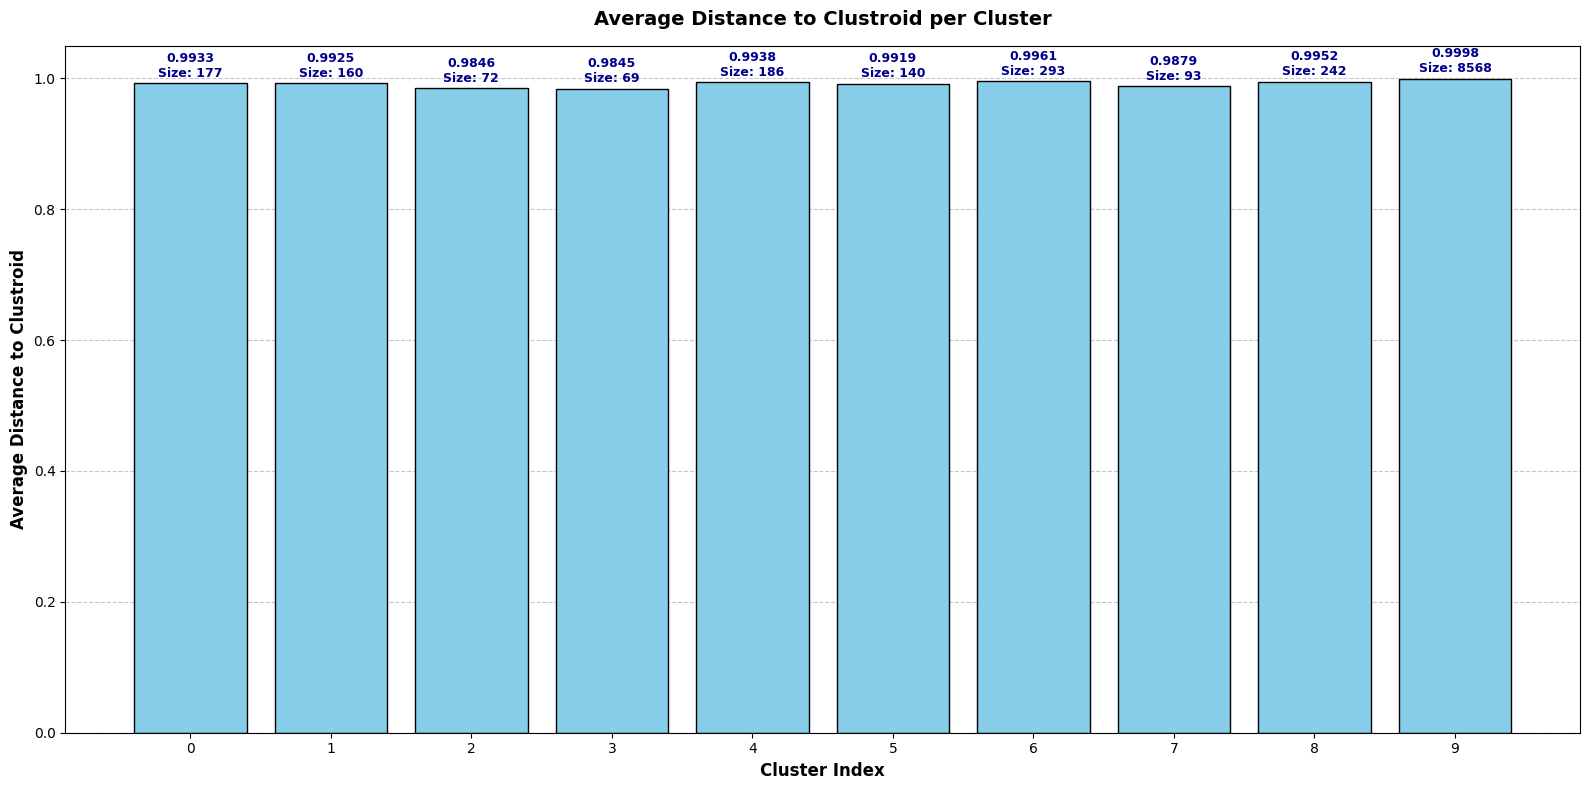

Chart plotting completed.


In [ ]:
# Step 5: Compute average distances and plot
print("Computing average distance to clustroid for each cluster...")
avg_distances = []
cluster_sizes = [] 
for i, cluster in enumerate(clusters):
    clustroid = model.compute_clustroid(cluster)
    distances = [model.distance_matrix[i][clustroid] for i in cluster]
    avg_dist = np.mean(distances) if distances else 0
    size = len(cluster) 
    avg_distances.append(avg_dist)
    cluster_sizes.append(size)
    print(f"Cluster {i}: Size = {size}, Average distance = {avg_dist:.4f}")

print("Plotting chart...")
fig, ax = plt.subplots(figsize=(16, 8)) 

# Create bar plot with a single color
bars = ax.bar(
    range(len(avg_distances)),
    avg_distances,
    color='skyblue',
    edgecolor='black',
    width=0.8
)

# Customize axes
ax.set_xlabel('Cluster Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Distance to Clustroid', fontsize=12, fontweight='bold')
ax.set_title('Average Distance to Clustroid per Cluster', fontsize=14, fontweight='bold', pad=15)

# Ensure all cluster indices are shown on x-axis
ax.set_xticks(range(len(avg_distances)))
ax.set_xticklabels(range(len(avg_distances)), fontsize=10)

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add text labels on top of each bar (average distance and size)
for bar, avg_dist, size in zip(bars, avg_distances, cluster_sizes):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f'{avg_dist:.4f}\nSize: {size}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color='darkblue'
    )

plt.tight_layout()
plt.savefig('clustroid_distances.png')
plt.show()
print("Chart plotting completed.")